### WORKOUT TYPE CLASSIFIER

#### 0. PREREQUISITES

Load necessary libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#### 1. Load data

The dataset was downloaded from Kaggle as a CSV file and trasformed into a DataFrame. Initially the dataset had 4 different classes. To be able to use a RandomForest model 2 classes were dropped (Cardio, Strength). Before dropping the classes the model was testes with different classes, as Yoga and HITT produced the best results, the two were selected. 

In [2]:
# Download latest version
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/phquadt/.cache/kagglehub/datasets/valakhorasani/gym-members-exercise-dataset/versions/1


In [3]:
# Example: Load a CSV file from the dataset path
data = pd.read_csv('data/gym_members_exercise_tracking.csv')
data.head(5)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [4]:
#Drop HIIT and Strength workout-type to only have to classes
data = data[~data['Workout_Type'].isin(['Cardio', 'Strength'])]


#### 2. Preprocessing and EDA

In the next step the data was analyzed. To make it easier to work with the dataset all columns were renamed. The data was checked for Null-Values which didn't exist and columns that didn't seem to be necessary (level of experience) were dropped.

Categorical variables (Gender) were transformed to numerical variables. 



In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 971
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            460 non-null    int64  
 1   Gender                         460 non-null    object 
 2   Weight (kg)                    460 non-null    float64
 3   Height (m)                     460 non-null    float64
 4   Max_BPM                        460 non-null    int64  
 5   Avg_BPM                        460 non-null    int64  
 6   Resting_BPM                    460 non-null    int64  
 7   Session_Duration (hours)       460 non-null    float64
 8   Calories_Burned                460 non-null    float64
 9   Workout_Type                   460 non-null    object 
 10  Fat_Percentage                 460 non-null    float64
 11  Water_Intake (liters)          460 non-null    float64
 12  Workout_Frequency (days/week)  460 non-null    int64  


In [6]:
data = data.rename(columns={
    'Workout_Type': 'workout_type', 
    'Weight (kg)' : 'weight',
    'Height (m)': 'height',
    'Max_BPM': 'max_bpm', 
    'Avg_BPM': 'avg_bpm', 
    'Resting_BPM': 'resting_bpm', 
    'Session_Duration (hours)': 'session_duration',
    'Calories_Burned': 'calories_burned',
    'Fat_Percentage': 'fat_percentage',
    'Water_Intake (liters)': 'water_intake',
    'Workout_Frequency (days/week)': 'workout_frequency',
    'Experience_Level': 'experience_level',
    'BMI': 'bmi', 
    'Age': 'age', 
    'Gender': 'gender'
                            })

data.head(5)

,age,gender,weight,height,max_bpm,avg_bpm,resting_bpm,session_duration,calories_burned,workout_type,fat_percentage,water_intake,workout_frequency,experience_level,bmi
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
10,41,Male,120.8,1.67,188,146,54,0.82,593.0,HIIT,20.5,3.0,2,1,43.31
11,53,Male,51.7,1.70,175,152,72,1.15,865.0,HIIT,23.6,3.5,3,2,17.89


In [7]:
#Check data types and look for Null-values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 971
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                460 non-null    int64  
 1   gender             460 non-null    object 
 2   weight             460 non-null    float64
 3   height             460 non-null    float64
 4   max_bpm            460 non-null    int64  
 5   avg_bpm            460 non-null    int64  
 6   resting_bpm        460 non-null    int64  
 7   session_duration   460 non-null    float64
 8   calories_burned    460 non-null    float64
 9   workout_type       460 non-null    object 
 10  fat_percentage     460 non-null    float64
 11  water_intake       460 non-null    float64
 12  workout_frequency  460 non-null    int64  
 13  experience_level   460 non-null    int64  
 14  bmi                460 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 57.5+ KB


In [8]:
#Drop irrelevant colums experience level
data = data.drop(columns=['experience_level'])
data.head(5)

,age,gender,weight,height,max_bpm,avg_bpm,resting_bpm,session_duration,calories_burned,workout_type,fat_percentage,water_intake,workout_frequency,bmi
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,32.00
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,20.55
10,41,Male,120.8,1.67,188,146,54,0.82,593.0,HIIT,20.5,3.0,2,43.31
11,53,Male,51.7,1.70,175,152,72,1.15,865.0,HIIT,23.6,3.5,3,17.89


In [9]:
#Analyze dataset
data.describe()

,age,weight,height,max_bpm,avg_bpm,resting_bpm,session_duration,calories_burned,fat_percentage,water_intake,workout_frequency,bmi
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.00000,460.000000
mean,39.095652,74.242826,1.727565,180.369565,143.391304,62.217391,1.274478,914.054348,24.472826,2.647391,3.35000,24.860739
std,12.179646,21.356322,0.128046,11.451439,14.148109,7.395203,0.345888,275.284213,6.373063,0.602910,0.92018,6.613802
min,18.000000,40.000000,1.500000,160.000000,120.000000,50.000000,0.500000,330.000000,10.100000,1.500000,2.00000,12.730000
25%,28.750000,58.175000,1.620000,171.000000,131.000000,56.000000,1.047500,714.750000,20.800000,2.200000,3.00000,20.092500
50%,41.000000,70.350000,1.710000,181.000000,142.000000,63.000000,1.280000,886.000000,25.850000,2.700000,3.00000,23.935000
75%,50.000000,86.425000,1.810000,190.000000,155.250000,68.000000,1.480000,1104.750000,28.900000,3.200000,4.00000,28.467500
max,59.000000,129.900000,2.000000,199.000000,169.000000,74.000000,1.990000,1766.000000,35.000000,3.700000,5.00000,49.840000


In [10]:
#Transform Gender to numerical values
data['gender']= data['gender'].map({'Male':0, 'Female':1})

#### 3. Prepare the Model 

The dataset was divided into the target variable y (workouttype) and features. 

A correlation analysis was conducted. Based on the results of the correlation matrix all variables with a corrlation value >0.5 were removed from the dataset (weight, height, age, session_duration, calories_burned, workout_frequency)

In [11]:
#Split data into target (workout_type) and features; drop columns with high correlation
X = data.drop(columns=['workout_type', 'weight', 'height', 'age', 'session_duration', 'calories_burned', 'workout_frequency'])
y = data['workout_type']

In [12]:
X

,gender,max_bpm,avg_bpm,resting_bpm,fat_percentage,water_intake,bmi
0,0,180,157,60,12.6,3.5,30.20
1,1,179,151,66,33.9,2.1,32.00
5,1,168,156,74,15.5,2.7,20.55
10,0,188,146,54,20.5,3.0,43.31
11,0,175,152,72,23.6,3.5,17.89
...,...,...,...,...,...,...,...
962,0,172,166,67,13.3,3.5,30.63
965,1,196,122,58,25.7,2.7,16.80
966,0,164,129,58,11.8,3.5,23.93
967,0,172,168,67,24.0,3.2,21.48


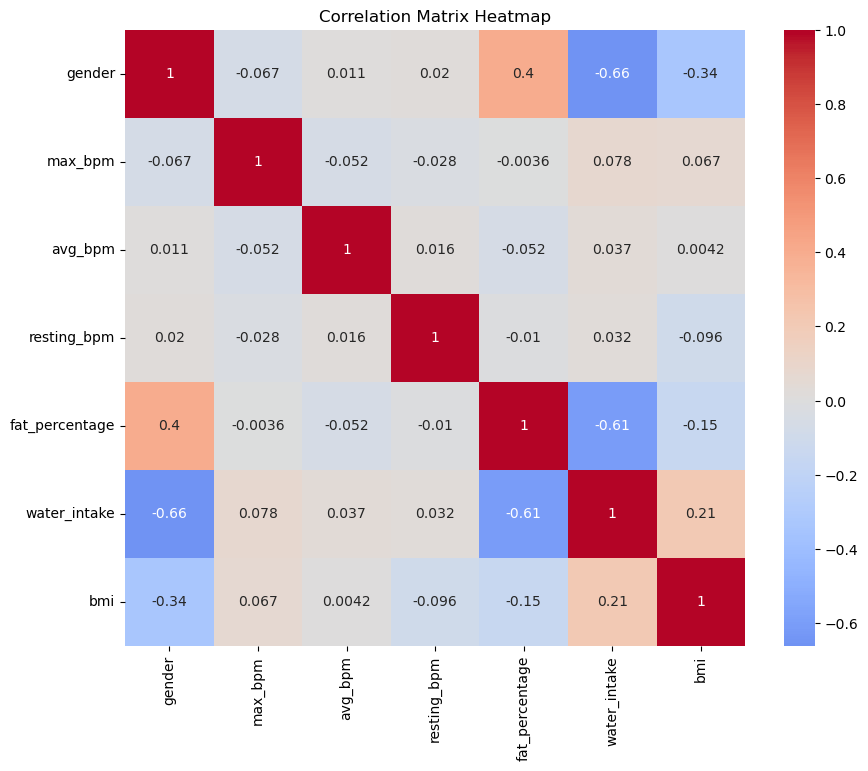

In [13]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### 4. Classification

The dataset was split into a train and test dataset and the model was fitted on the train data. The accurancy score for the model on the test data was 0.56. For more insides a classification report was created. Also the individual features were observed regarding their importance. The feature importance seems to be quite balanced, only the gender seems to be not significantly important. 

In [14]:
#Split data into train and test set 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=19)

In [15]:
#Initiate the RandomForestModel
rf = RandomForestClassifier()

In [16]:
#Fit the model on the train data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
#Evaluate the model on the test data
rf.score(X_test,y_test)

0.5579710144927537

In [18]:
#Calculate and compare accuracy score for test and train data
pred_test = rf.predict(X_test)
accuracy_score(y_test,pred_test)

0.5579710144927537

In [19]:
pred_train = rf.predict(X_train)
accuracy_score(y_train,pred_train)

1.0

In [20]:
#Print classification matrix for test data
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

        HIIT       0.61      0.45      0.52        73
        Yoga       0.52      0.68      0.59        65

    accuracy                           0.56       138
   macro avg       0.57      0.56      0.56       138
weighted avg       0.57      0.56      0.55       138



In [21]:
#Calculate feature importance to see if relevant features were selected
features = pd.DataFrame(rf.feature_importances_, index=X.columns)
features

,0
gender,0.019794
max_bpm,0.171718
avg_bpm,0.168254
resting_bpm,0.149236
fat_percentage,0.182857
water_intake,0.117762
bmi,0.190379


#### 5. Hyperparameter Tuning

In order to improve the model a second model with changed params. To find the best parameters a Grid Search was conducted. Based on the results a second RandomForest Model was calculated. Unfortunately the model didn't improve through the changes in the hyper parameters. 

In [22]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None,10, 20],
    'min_samples_split': [2, 5]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# After fitting, you can access the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Access the best estimator after grid search
rf = grid_search.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.5062980769230769


In [23]:
rf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10    ,
    random_state=42,
    min_samples_leaf=4,
    min_samples_split=2,
    #max_features='sqrt',
    #bootstrap=True,
    criterion='gini',
    #max_leaf_nodes=None,
    #min_impurity_decrease=0.0
)

In [24]:
rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, random_state=42)

In [25]:
rf2.score(X_test, y_test)

0.5362318840579711

In [26]:
pred2_test = rf2.predict(X_test)

In [27]:
print(classification_report(y_test, pred2_test))

              precision    recall  f1-score   support

        HIIT       0.61      0.34      0.44        73
        Yoga       0.51      0.75      0.60        65

    accuracy                           0.54       138
   macro avg       0.56      0.55      0.52       138
weighted avg       0.56      0.54      0.52       138



In [28]:
# Accuracy score
print(accuracy_score(y_test, pred2_test))

pred2_train = rf2.predict(X_train)

# Accuracy score
print(accuracy_score(y_train, pred2_train))

0.5362318840579711
0.9409937888198758


#### 6. Saving Model 

The first model (due to higher score) was saved and a pickle file exported to be able to use it as part of the streamlit application. 

In [31]:
# Saving the trained RandomForestClassifier model to a pickle file
import pickle
pickle_out = open("classifier.pkl", mode = "wb")
pickle.dump(rf, pickle_out)
pickle_out.close()